 Ehsan Honarbakhsh 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage import data, img_as_float
from skimage.metrics import mean_squared_error
import pandas as pd

# Task1 :
## Reading PGM file

In [22]:
def read_pgm(filename):
    index=open(filename,'rb')
    len_index=index.readline().split()
    with open(filename, 'rb') as f:
        # Read magic number
        if len(len_index) ==1 :
            magic_number = f.readline().decode().strip()
            if magic_number not in ('P2', 'P5'):
                raise ValueError("Unsupported PGM format!")
        
            # Skip comments
            while True:
                line = f.readline().decode().strip()
                if line.startswith('#'):
                    continue
                else:
                    break
        
            # Read dimensions
            width, height = map(int, line.split())
        
            # Read max gray value
            max_gray = int(f.readline().decode().strip())
            
            # Read pixel data
            if magic_number == 'P2':
                # ASCII format
                pixel_data = []
                for line in f:
                    pixel_data.extend(map(int,line.decode().split()))
                pixels = np.array(pixel_data, dtype=np.uint8).reshape((height, width))
            elif magic_number == 'P5':
                # Binary format
                pixel_data = f.read()
                pixels = np.frombuffer(pixel_data, dtype=np.uint8).reshape((height, width))
        
            return pixels
        else:
            assert len(len_index)>1
            firstline_chunks=f.readline().decode().split()
            width, height = map(int, (firstline_chunks[1],firstline_chunks[2]))
            max_gray = int(firstline_chunks[3])
            if firstline_chunks[0] == 'P2':
                # ASCII format
                pixel_data = []
                for line in f:
                    pixel_data.extend(map(int,line.decode().split()))
                pixels = np.array(pixel_data, dtype=np.uint8).reshape((height, width))
            elif firstline_chunks[0] == 'P5':
                # Binary format
                pixel_data = f.read()
                pixels = np.frombuffer(pixel_data, dtype=np.uint8).reshape((height, width))
            return pixels
        
#Original Image:
pgm_image_original =  np.asarray(read_pgm('Dataset/original/barbara.pgm'))
#Noisy Image Image:
pgm_image_noisy = np.asarray(read_pgm('Dataset/noisy_1/barbara.pgm'))     

### Displaying PGM images

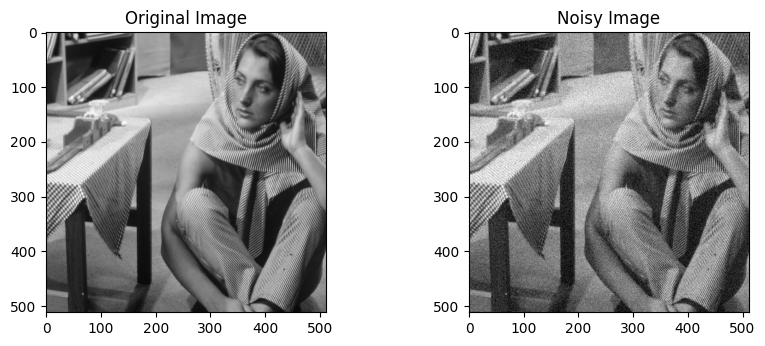

In [23]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(pgm_image_original, cmap='gray')
plt.subplot(2, 2, 2)
plt.title('Noisy Image')
plt.imshow(pgm_image_noisy, cmap='gray')

# Data Preprocessing

### Plotting the histogram for detecting the noise

(array([1269.,  147.,  147.,  194.,  215.,  230.,  237.,  265.,  276.,
         323.,  363.,  354.,  388.,  381.,  436.,  506.,  454.,  570.,
         598.,  587.,  692.,  648.,  698.,  735.,  782.,  783.,  837.,
         844.,  877.,  969.,  949.,  943., 1036.,  997., 1073., 1049.,
        1096., 1204., 1139., 1118., 1089., 1234., 1184., 1228., 1281.,
        1242., 1193., 1291., 1279., 1276., 1298., 1277., 1330., 1275.,
        1251., 1195., 1223., 1193., 1278., 1262., 1264., 1167., 1208.,
        1222., 1262., 1208., 1214., 1198., 1226., 1209., 1212., 1185.,
        1254., 1174., 1249., 1252., 1228., 1223., 1213., 1276., 1304.,
        1268., 1259., 1301., 1311., 1297., 1305., 1336., 1356., 1360.,
        1366., 1435., 1427., 1421., 1402., 1389., 1416., 1394., 1513.,
        1468., 1468., 1513., 1502., 1463., 1589., 1484., 1526., 1503.,
        1507., 1524., 1578., 1591., 1575., 1564., 1562., 1478., 1564.,
        1508., 1530., 1526., 1483., 1551., 1575., 1486., 1527., 1541.,
      

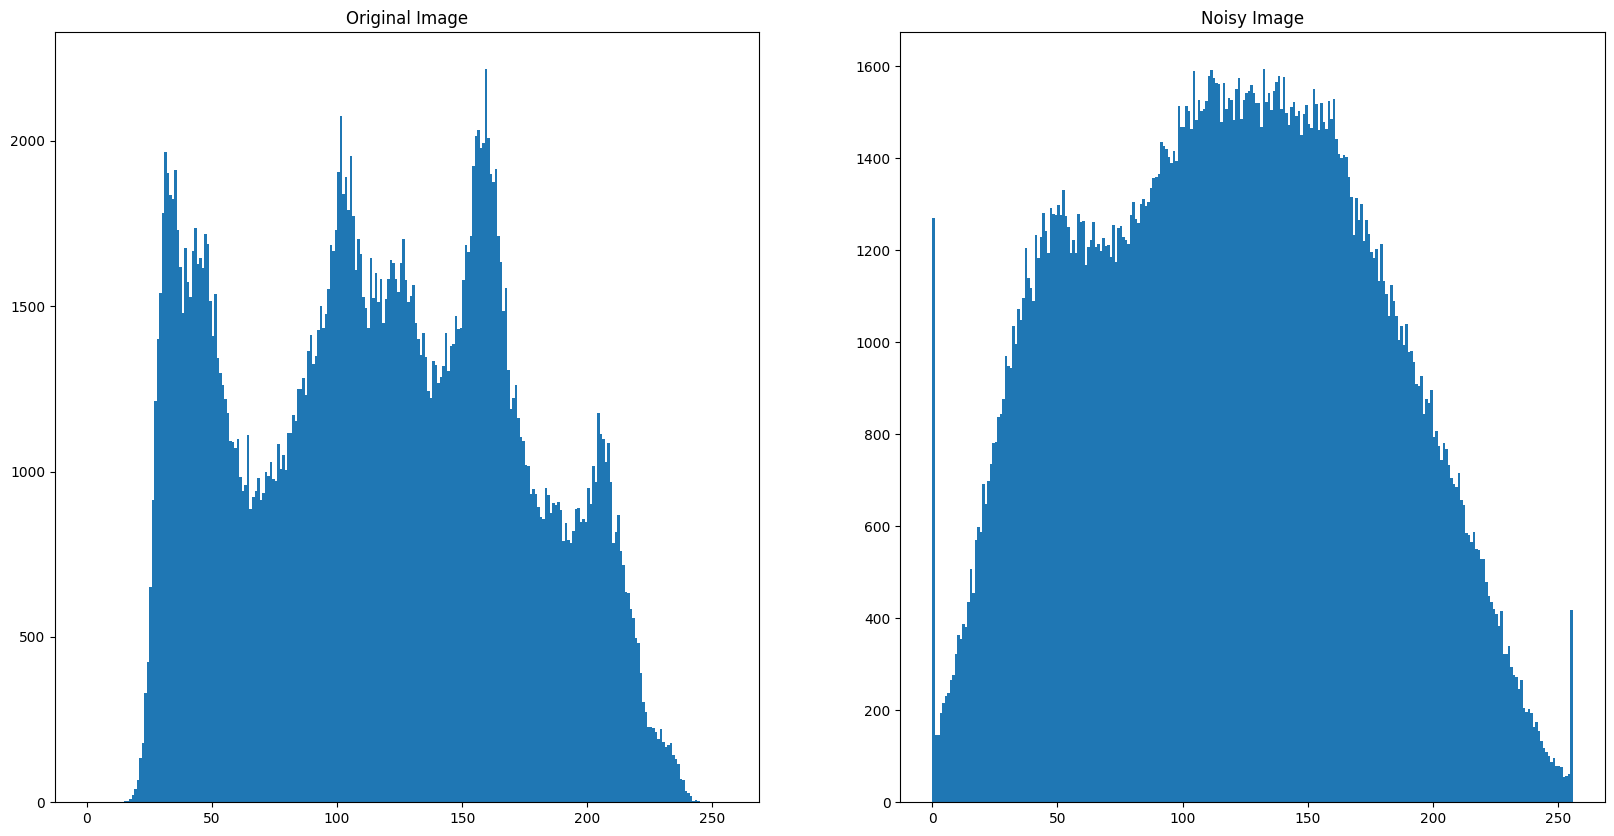

In [24]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.hist(pgm_image_original.ravel(), bins=256, range=[0, 256])
plt.subplot(1, 2, 2)
plt.title('Noisy Image')
plt.hist(pgm_image_noisy.ravel(), bins=256, range=[0, 256])

### Converting to float

In [10]:
#Convert an image to floating point format, with values in [0, 1]
image_float_original=img_as_float(pgm_image_original)
image_float_noisy=img_as_float(pgm_image_noisy)

### Padding Images


In [11]:
def pad_image(image):
    rows, cols = image.shape
    padded_rows = rows + (rows % 2)
    padded_cols = cols + (cols % 2)
    padded_image = np.zeros((padded_rows, padded_cols))
    padded_image[:rows, :cols] = image
    return padded_image
image_padded_original=pad_image(image_float_original)
image_padded_noisy=pad_image(image_float_noisy)

# Task 2:
###  Wavelet Decomposition and Reconstruction 

Defining haar wavelet filters

In [12]:
#Low-pass filter  [1/ √2, 1/ √2]
#High-pass filter [1/ √2, - 1/ √2] 
haar_wavelet={'low':[1/np.sqrt(2),1/np.sqrt(2)],
              'high':[1/np.sqrt(2),-1/np.sqrt(2)]}
level=3

In [13]:

def wavelet_decomposition(image,wavelet,level):
    
    low_filter=np.array(wavelet['low'])
    high_filter=np.array(wavelet['high'])
    coefficients=[]

    for i in range(level):
        if i==0:
            low_filter_rows=np.apply_along_axis( lambda row :np.convolve(row,low_filter,mode='full')[::2],
                                                axis=1 , arr=image) 
            high_filter_rows=np.apply_along_axis( lambda row :np.convolve(row,high_filter,mode='full')[::2],
                                                axis=1,arr=image)
            
            low_filter_column_low_row=np.apply_along_axis( lambda column:np.convolve(column,low_filter,mode='full')[::2],
                                                        axis=0,arr=low_filter_rows)
            high_filter_column_low_row=np.apply_along_axis( lambda column:np.convolve(column,high_filter,mode='full')[::2],
                                                        axis=0,arr=low_filter_rows)
            low_filter_column_high_row=np.apply_along_axis( lambda column:np.convolve(column,low_filter,mode='full')[::2],
                                                        axis=0,arr=high_filter_rows)
            high_filter_column_high_row=np.apply_along_axis( lambda column:np.convolve(column,high_filter,mode='full')[::2],
                                                        axis=0,arr=high_filter_rows)
        else:
            low_filter_rows_l=np.apply_along_axis( lambda row :np.convolve(row,low_filter,mode='full')[::2],
                                                axis=1 , arr=coefficients[i-1]['approximation'])
            high_filter_rows_l=np.apply_along_axis( lambda row :np.convolve(row,high_filter,mode='full')[::2],
                                                axis=1,arr=coefficients[i-1]['approximation'])
            
            low_filter_column_low_row=np.apply_along_axis( lambda column:np.convolve(column,low_filter,mode='full')[::2],
                                                        axis=0,arr=low_filter_rows_l)
            high_filter_column_low_row=np.apply_along_axis( lambda column:np.convolve(column,high_filter,mode='full')[::2],
                                                        axis=0,arr=low_filter_rows_l)
            low_filter_column_high_row=np.apply_along_axis( lambda column:np.convolve(column,low_filter,mode='full')[::2],
                                                        axis=0,arr=high_filter_rows_l)
            high_filter_column_high_row=np.apply_along_axis( lambda column:np.convolve(column,high_filter,mode='full')[::2],
                                                        axis=0,arr=high_filter_rows_l)
        
        coefficients.append({'approximation':low_filter_column_low_row,
                             'horizontal':high_filter_column_low_row,
                             'vertical':low_filter_column_high_row,
                             'diagonal': high_filter_column_high_row})    
    return coefficients    

wavelet_decomposition_coeff_original=wavelet_decomposition(image_padded_original,haar_wavelet,level)


Displaying coefficients

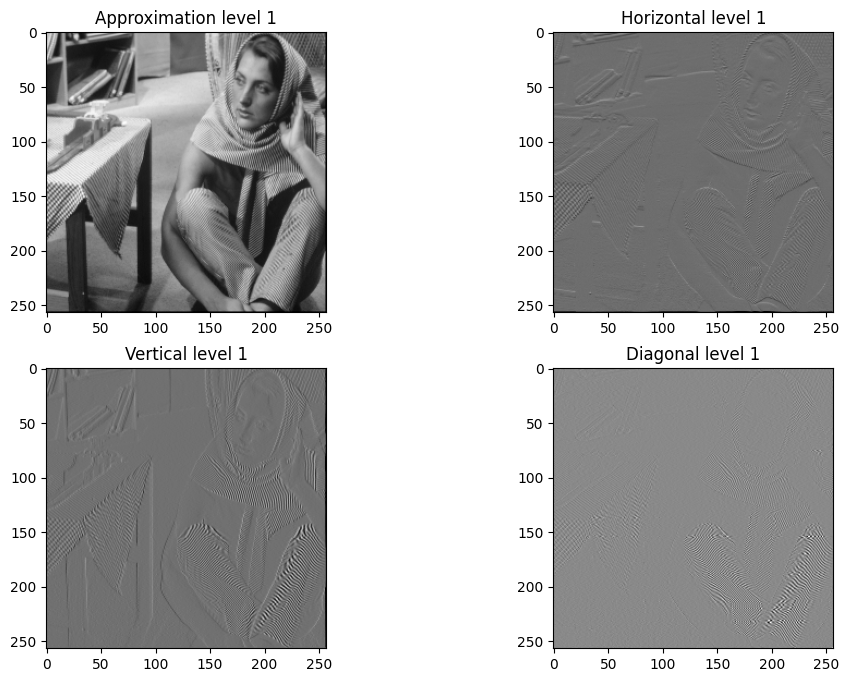

In [17]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title('Approximation level 1')
plt.imshow(wavelet_decomposition_coeff_original[0]['approximation'], cmap='gray')
plt.subplot(2, 2, 2)
plt.title('Horizontal level 1')
plt.imshow(wavelet_decomposition_coeff_original[0]['horizontal'], cmap='gray')
plt.subplot(2, 2, 3)
plt.title('Vertical level 1')
plt.imshow(wavelet_decomposition_coeff_original[0]['vertical'], cmap='gray')
plt.subplot(2, 2, 4)
plt.title('Diagonal level 1')
plt.imshow(wavelet_decomposition_coeff_original[0]['diagonal'], cmap='gray')
plt.show()

# Reconstruction (Original image)

In [18]:
low_filter=np.array(haar_wavelet['low'])
high_filter=np.array(haar_wavelet['high'])

def convolve_2d(wavelet_coefficient, filter_row, filter_col):
    row_convolution = convolve2d(wavelet_coefficient, filter_row[:, np.newaxis], mode='same')
    result_convolution = convolve2d(row_convolution, filter_col[np.newaxis, :], mode='same')
    return result_convolution

def upsample(wavelet_coefficient):
    upsampled_coefficient = np.zeros((wavelet_coefficient.shape[0] * 2, wavelet_coefficient.shape[1] * 2))
    upsampled_coefficient[::2, ::2] = wavelet_coefficient

    return upsampled_coefficient


def wavelet_reconstruct(wavelet_coefficient, low_filter, high_filter,level):
    reconstructed_image=[]
    for i in range(level):
        approximation_upsampled = upsample(wavelet_coefficient[i]['approximation'])
        horizontal_upsampled = upsample(wavelet_coefficient[i]['horizontal'])
        vertical_upsampled = upsample(wavelet_coefficient[i]['vertical'])
        diagnol_upsampled = upsample(wavelet_coefficient[i]['diagonal'])

        low_low = convolve_2d(approximation_upsampled, low_filter, low_filter)
        low_high = convolve_2d(horizontal_upsampled, low_filter, high_filter)
        high_low = convolve_2d(vertical_upsampled, high_filter, low_filter)
        high_high = convolve_2d(diagnol_upsampled, high_filter, high_filter)
        
        sum_subbands=low_low + low_high + high_low + high_high
        reconstructed_image.append(sum_subbands)
    return reconstructed_image

reconstructed_image_original = wavelet_reconstruct(wavelet_decomposition_coeff_original, low_filter, high_filter,level)


In [19]:
reconstructed_image_original=reconstructed_image_original[0]

if image_float_original.shape[0] % 2 == 0:
    reconstructed_image_original=reconstructed_image_original[:image_padded_original.shape[0], :image_padded_original.shape[1]]
else:
    reconstructed_image_original=reconstructed_image_original[:image_float_original.shape[0], :image_float_original.shape[1]]


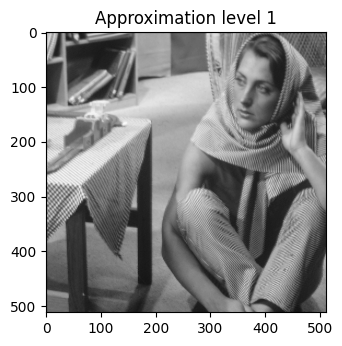

In [20]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title('Approximation level 1')
plt.imshow(reconstructed_image_original, cmap='gray')

## MSE between the original image and the reconstructed image

In [21]:
mse_original= mean_squared_error(image_float_original,reconstructed_image_original)
print("The MSE between the original image and the reconstructed image :" ,mse_original)

The MSE between the original image and the reconstructed image : 0.009388990508552148


# Task3
### Deonoising algorithm using wavelet decomposition and reconstruction algorithm

In [25]:

haar_wavelet={'low':[1/np.sqrt(2),1/np.sqrt(2)],
              'high':[1/np.sqrt(2),-1/np.sqrt(2)]}
level=3

def wavelet_decomposition(image,wavelet,level):
    
    low_filter=np.array(wavelet['low'])
    high_filter=np.array(wavelet['high'])
    coefficients=[]

    for i in range(level):
        if i==0:
            low_filter_rows=np.apply_along_axis( lambda row :np.convolve(row,low_filter,mode='full')[::2],
                                                axis=1 , arr=image)
            high_filter_rows=np.apply_along_axis( lambda row :np.convolve(row,high_filter,mode='full')[::2],
                                                axis=1,arr=image)
            
            low_filter_column_low_row=np.apply_along_axis( lambda column:np.convolve(column,low_filter,mode='full')[::2],
                                                        axis=0,arr=low_filter_rows)
            high_filter_column_low_row=np.apply_along_axis( lambda column:np.convolve(column,high_filter,mode='full')[::2],
                                                        axis=0,arr=low_filter_rows)
            low_filter_column_high_row=np.apply_along_axis( lambda column:np.convolve(column,low_filter,mode='full')[::2],
                                                        axis=0,arr=high_filter_rows)
            high_filter_column_high_row=np.apply_along_axis( lambda column:np.convolve(column,high_filter,mode='full')[::2],
                                                        axis=0,arr=high_filter_rows)
        else:
            low_filter_rows_l=np.apply_along_axis( lambda row :np.convolve(row,low_filter,mode='full')[::2],
                                                axis=1 , arr=coefficients[i-1]['approximation'])
            high_filter_rows_l=np.apply_along_axis( lambda row :np.convolve(row,high_filter,mode='full')[::2],
                                                axis=1,arr=coefficients[i-1]['approximation'])
            
            low_filter_column_low_row=np.apply_along_axis( lambda column:np.convolve(column,low_filter,mode='full')[::2],
                                                        axis=0,arr=low_filter_rows_l)
            high_filter_column_low_row=np.apply_along_axis( lambda column:np.convolve(column,high_filter,mode='full')[::2],
                                                        axis=0,arr=low_filter_rows_l)
            low_filter_column_high_row=np.apply_along_axis( lambda column:np.convolve(column,low_filter,mode='full')[::2],
                                                        axis=0,arr=high_filter_rows_l)
            high_filter_column_high_row=np.apply_along_axis( lambda column:np.convolve(column,high_filter,mode='full')[::2],
                                                        axis=0,arr=high_filter_rows_l)
        
        coefficients.append({'approximation':low_filter_column_low_row,
                             'horizontal':high_filter_column_low_row,
                             'vertical':low_filter_column_high_row,
                             'diagnol': high_filter_column_high_row})    

        #image=low_filter_column_low_row
    return coefficients    

def denoising_method(wavelet_coefficient,thresholding_method):
    assert wavelet_coefficient !=0
    assert thresholding_method in ['hard','soft']
    for i in  range(level):
  
            wavelet_coefficient[i]['approximation'] = median_denoising_filter(wavelet_coefficient[i]['approximation'],3)
            wavelet_coefficient[i]['horizontal'] = thresholding(wavelet_coefficient[i]['horizontal'], noise_variance(wavelet_coefficient[i]['diagnol']),thresholding_method)
            wavelet_coefficient[i]['vertical'] = thresholding(wavelet_coefficient[i]['vertical'], noise_variance(wavelet_coefficient[i]['diagnol']),thresholding_method)
            wavelet_coefficient[i]['diagnol'] = thresholding(wavelet_coefficient[i]['diagnol'], noise_variance(wavelet_coefficient[i]['diagnol']),thresholding_method)

    return wavelet_coefficient
    
def median_denoising_filter(wavelet_coefficient,kernel_size):    
    assert (kernel_size % 2) != 0 
    pad_size = kernel_size // 2
    padded_coefficient = np.pad(wavelet_coefficient, pad_size, mode='edge')
    median_filtered_coefficient = np.zeros_like(wavelet_coefficient)

    for i in range(wavelet_coefficient.shape[0]):
        for j in range(wavelet_coefficient.shape[1]):
            neighborhood = padded_coefficient[i:i+kernel_size, j:j+kernel_size]
            median_filtered_coefficient[i, j] = np.median(neighborhood)
    
    return median_filtered_coefficient
#The factor 0.6745 comes from a normal distribution property. Specifically, in the context of Gaussian noise, the median of the absolute deviations of a normally distributed set of values is approximately 0.6745 times the standard deviation.
def noise_variance(diagnol_coefficient):
    sigma = np.median(np.abs(diagnol_coefficient)) / 0.6745
    return sigma**2

def thresholding(wavelet_coefficient,noise,thresholding_method):
    rows, cols = wavelet_coefficient.shape
    total_variance = np.var(wavelet_coefficient)
    coefficient_variance = max(total_variance - noise, 0)

    thresholded_coefficients = np.zeros_like(wavelet_coefficient, dtype=np.float64)
    for i in range(rows):
        for j in range(cols):

            T = np.sqrt(noise) - np.sqrt(coefficient_variance)
            if abs(wavelet_coefficient[i, j] - np.mean(wavelet_coefficient)) > T:
                thresholded_coefficients[i, j] =0
            else:
                if thresholding_method == 'soft': 
                    thresholded_coefficients[i, j] = np.sign(wavelet_coefficient[i, j]) * np.maximum(np.abs(wavelet_coefficient[i, j]) - T, 0)
                elif thresholding_method == 'hard':
                    thresholded_coefficients[i, j] = wavelet_coefficient[i, j]
                else:
                    raise ValueError("Invalid thresholding method")      
                
    return thresholded_coefficients


low_filter=np.array(haar_wavelet['low'])
high_filter=np.array(haar_wavelet['high'])

def convolve_2d(wavelet_coefficient, filter_row, filter_col):
    row_convolution = convolve2d(wavelet_coefficient, filter_row[:, np.newaxis], mode='same')
    result_convolution = convolve2d(row_convolution, filter_col[np.newaxis, :], mode='same')
    return result_convolution

def upsample(wavelet_coefficient):
    upsampled_coefficient = np.zeros((wavelet_coefficient.shape[0] * 2, wavelet_coefficient.shape[1] * 2))
    upsampled_coefficient[::2, ::2] = wavelet_coefficient
    return upsampled_coefficient

def wavelet_reconstruction(wavelet_coefficient, low_filter, high_filter,level):
    reconstructed_image=[]
    for i in range(level):
        approximation_upsampled = upsample(wavelet_coefficient[i]['approximation'])
        horizontal_upsampled = upsample(wavelet_coefficient[i]['horizontal'])
        vertical_upsampled = upsample(wavelet_coefficient[i]['vertical'])
        diagnol_upsampled = upsample(wavelet_coefficient[i]['diagnol'])

        low_low = convolve_2d(approximation_upsampled, low_filter, low_filter)
        low_high = convolve_2d(horizontal_upsampled, low_filter, high_filter)
        high_low = convolve_2d(vertical_upsampled, high_filter, low_filter)
        high_high = convolve_2d(diagnol_upsampled, high_filter, high_filter)

        sum_subbands=low_low + low_high + high_low + high_high
        reconstructed_image.append(sum_subbands)

    return reconstructed_image


wavelet_coefficient=wavelet_decomposition(image_padded_noisy,haar_wavelet,level)
denoised_coefficients=denoising_method(wavelet_coefficient,thresholding_method='hard')
reconstructed_denoised_image = wavelet_reconstruction(denoised_coefficients, low_filter, high_filter,level)


In [26]:
reconstructed_denoised_image=reconstructed_denoised_image[0]

if image_float_noisy.shape[0] % 2 == 0:
    reconstructed_denoised_image=reconstructed_denoised_image[:image_padded_noisy.shape[0], :image_padded_noisy.shape[1]]
else:
    reconstructed_denoised_image=reconstructed_denoised_image[:image_float_noisy.shape[0], :image_float_noisy.shape[1]]


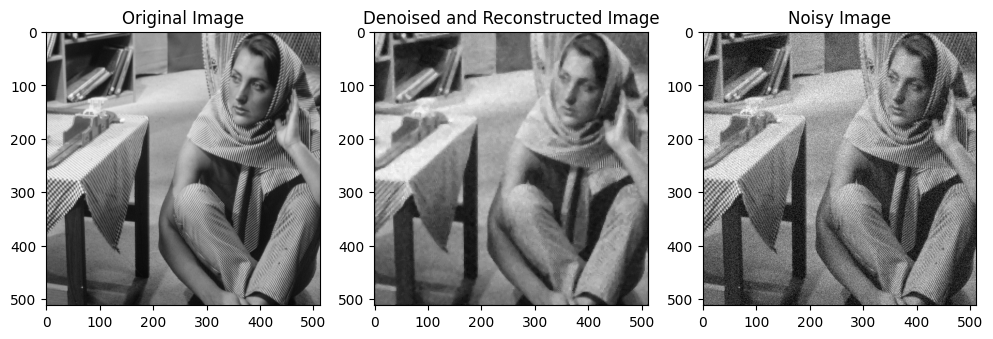

In [27]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_float_original, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Denoised and Reconstructed Image')
plt.imshow(reconstructed_denoised_image, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('Noisy Image')
plt.imshow(image_float_noisy, cmap='gray')
plt.show()

# MSE

In [28]:
mse_original_denoised= mean_squared_error(image_float_original,reconstructed_denoised_image)
mse_noisy_denoised= mean_squared_error(image_float_noisy,reconstructed_denoised_image)
print("The MSE between the original image and the denoised reconstructed image :" ,mse_original_denoised)
print("The MSE between the noisy image and the denoised reconstructed image    :" ,mse_noisy_denoised)

The MSE between the original image and the denoised reconstructed image : 0.006477206302394963
The MSE between the noisy image and the denoised reconstructed image    : 0.011048238212353722


# SSIM:
 It is a widely used metric that assesses the structural similarity between two images. It considers luminance, contrast, and structure, giving a score between -1 (dissimilar) and 1 (identical). The scikit-image library in Python offers an SSIM implementation

In [56]:
from skimage.metrics import structural_similarity as ssim
ssim_original_denoised = ssim(reconstructed_denoised_image,image_float_original, data_range=image_float_original.max() - image_float_original.min())
ssim_noise2 = ssim(reconstructed_denoised_image,image_float_noisy, data_range=image_float_noisy.max() - image_float_noisy.min())
print("The SSIM between the original image and the denoised reconstructed image :" ,ssim_original_denoised)
print("The SSIM between the noisy image and the denoised reconstructed image    :" ,ssim_noise2)

The SSIM between the original image and the denoised reconstructed image : 0.5345641090093948
The SSIM between the noisy image and the denoised reconstructed image    : 0.28648007357578725


# Evaluation and Comparison 


## Mean Filter


In [57]:
def mean_filter(image, kernel_size):

    assert (kernel_size % 2) != 0
    height, width = image.shape
    pad_size = kernel_size // 2
    padded_image = np.zeros((height + 2 * pad_size, width + 2 * pad_size))
    padded_image[pad_size:-pad_size, pad_size:-pad_size] = image
    output_image = np.zeros_like(image)

    for i in range(height):
        for j in range(width):
            window = padded_image[i:i + kernel_size, j:j + kernel_size]
            output_image[i, j] = np.mean(window)

    return output_image

mean_denoised_image = mean_filter(image_float_noisy, kernel_size=5)


## Median Filter

In [58]:
def median_denoising_filter(wavelet_coefficient,kernel_size):    
    assert (kernel_size % 2) != 0 
    pad_size = kernel_size // 2
    padded_coefficient = np.pad(wavelet_coefficient, pad_size, mode='edge')
    median_filtered_coefficient = np.zeros_like(wavelet_coefficient)
    for i in range(wavelet_coefficient.shape[0]):
        for j in range(wavelet_coefficient.shape[1]):
            neighborhood = padded_coefficient[i:i+kernel_size, j:j+kernel_size]
            median_filtered_coefficient[i, j] = np.median(neighborhood)
    
    return median_filtered_coefficient

median_denoised_image=median_denoising_filter(image_float_noisy,kernel_size=5)

In [59]:
from skimage.restoration import denoise_wavelet, estimate_sigma
sigma_est = estimate_sigma(image_float_noisy, channel_axis=-1, average_sigmas=True)
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

Estimated Gaussian noise standard deviation = 0.07700404301670752


In [60]:
BayesShrink_denoised_image = denoise_wavelet(
    image_float_noisy,
    wavelet='haar',
    wavelet_levels=3,
    method='BayesShrink',
    mode='soft',
    rescale_sigma=True,
)
VisuShrink_denoised_image = denoise_wavelet(
    image_float_noisy,
    wavelet='haar',
    wavelet_levels=3,
    method='VisuShrink',
    mode='soft',
    sigma=sigma_est/12,
    rescale_sigma=True,
)

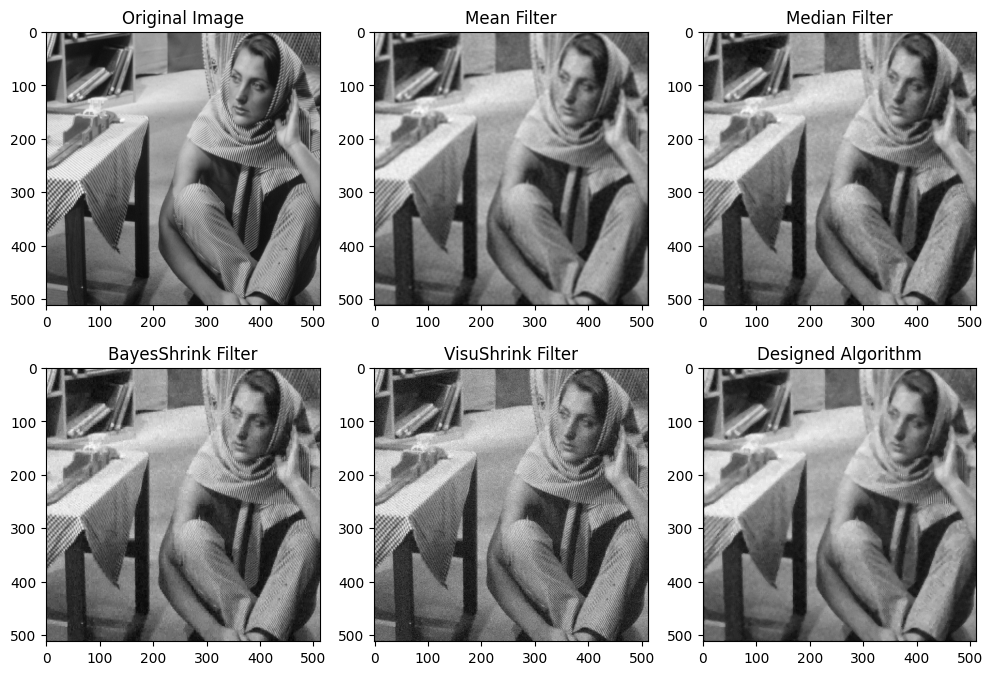

In [61]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(image_float_original, cmap='gray')
plt.subplot(2, 3, 2)
plt.title('Mean Filter')
plt.imshow(mean_denoised_image, cmap='gray')
plt.subplot(2, 3, 3)
plt.title('Median Filter')
plt.imshow(median_denoised_image, cmap='gray')
plt.subplot(2, 3, 4)
plt.title('BayesShrink Filter')
plt.imshow(BayesShrink_denoised_image, cmap='gray')
plt.subplot(2, 3, 5)
plt.title('VisuShrink Filter')
plt.imshow(VisuShrink_denoised_image, cmap='gray')
plt.subplot(2, 3, 6)
plt.title('Designed Algorithm')
plt.imshow(reconstructed_denoised_image, cmap='gray')
plt.show()

# MSE Comparison:

In [62]:
mse_mean_original_denoised= mean_squared_error(image_float_original,mean_denoised_image)
mse_median_original_denoised= mean_squared_error(image_float_original,median_denoised_image)
mse_BayesShrink_original_denoised= mean_squared_error(image_float_original,BayesShrink_denoised_image)
mse_VisuShrink_original_denoised= mean_squared_error(image_float_original,VisuShrink_denoised_image)
print('1.The MSE for image deniosed by Mean filter        : ', mse_mean_original_denoised)
print('2.The MSE for image deniosed by Median filter      : ', mse_median_original_denoised)
print('1.The MSE for image deniosed by BayesShrink filter : ', mse_BayesShrink_original_denoised)
print('2.The MSE for image deniosed by VisuShrink filter  : ', mse_VisuShrink_original_denoised)
print('3.The MSE for image deniosed by My Own filter      : ', mse_original_denoised)

1.The MSE for image deniosed by Mean filter        :  0.005152116864231907
2.The MSE for image deniosed by Median filter      :  0.005120044548389591
1.The MSE for image deniosed by BayesShrink filter :  0.0023363631386700786
2.The MSE for image deniosed by VisuShrink filter  :  0.002942038362100225
3.The MSE for image deniosed by My Own filter      :  0.006477206302394963


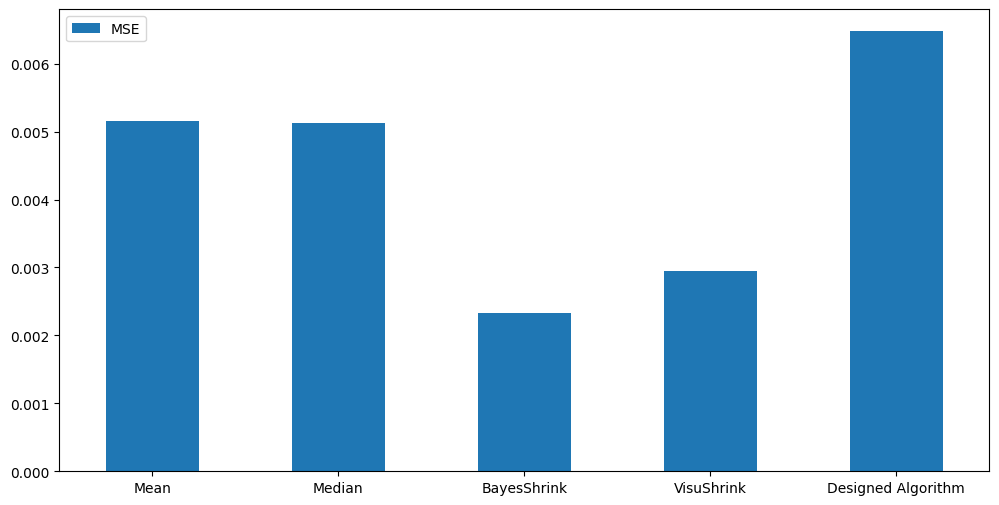

In [63]:
import pandas as pd
mse = [mse_mean_original_denoised,mse_median_original_denoised,mse_BayesShrink_original_denoised,
             mse_VisuShrink_original_denoised,mse_original_denoised]

index = ['Mean','Median','BayesShrink','VisuShrink','Designed Algorithm']
df = pd.DataFrame({'MSE': mse}, index=index)
ax = df.plot.bar(rot=0,figsize=(12, 6))

# SSIM Comparison

In [64]:
ssim_mean_original_denoised = ssim(mean_denoised_image,image_float_original, data_range=image_float_original.max() - image_float_original.min())
ssim_median_original_denoised = ssim(median_denoised_image,image_float_original, data_range=image_float_original.max() - image_float_original.min())
ssim_BayesShrink_original_denoised = ssim(BayesShrink_denoised_image,image_float_original, data_range=image_float_original.max() - image_float_original.min())
ssim_VisuShrink_original_denoised = ssim(VisuShrink_denoised_image,image_float_original, data_range=image_float_original.max() - image_float_original.min())
ssim_original_denoised = ssim(reconstructed_denoised_image,image_float_original, data_range=image_float_original.max() - image_float_original.min())


print('1.The SSIM for image deniosed by Mean filter        :',ssim_mean_original_denoised)
print('2.The SSIM for image deniosed by Median filter      :',ssim_median_original_denoised)
print('2.The SSIM for image deniosed by BayesShrink filter :',ssim_BayesShrink_original_denoised )
print('2.The SSIM for image deniosed by VisuShrink filter  :',ssim_VisuShrink_original_denoised)
print('3.The SSIM for image deniosed by my own filter      :',ssim_original_denoised)

1.The SSIM for image deniosed by Mean filter        : 0.6176147337382913
2.The SSIM for image deniosed by Median filter      : 0.5964345130670263
2.The SSIM for image deniosed by BayesShrink filter : 0.722275133190908
2.The SSIM for image deniosed by VisuShrink filter  : 0.6144773317330754
3.The SSIM for image deniosed by my own filter      : 0.5345641090093948


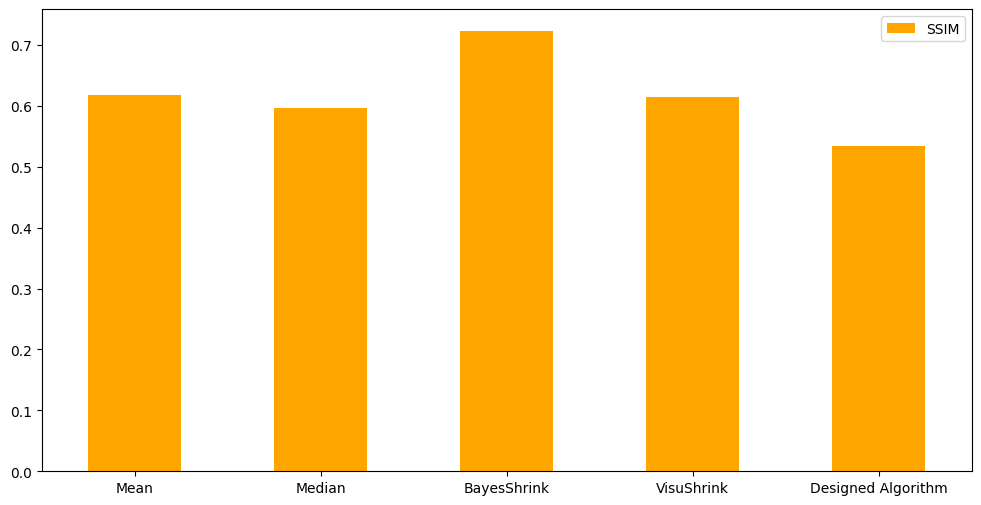

In [65]:
import pandas as pd
ssim = [ssim_mean_original_denoised,ssim_median_original_denoised,ssim_BayesShrink_original_denoised,
      ssim_VisuShrink_original_denoised,ssim_original_denoised]

index = ['Mean','Median','BayesShrink','VisuShrink','Designed Algorithm']
df = pd.DataFrame({'SSIM':ssim}, index=index)
ax = df.plot.bar(rot=0,figsize=(12, 6),color='orange')